# Study of Population Growth of U.S. Counties

There are over 3000 counties in the United States. Although the U.S. population is increasing as a whole, it is safe to assume that this population growth is not equally distributed across all counties. In this study, I will take a look at county-level data regarding population, employment, income, education, and rural-urban classification.  I am interested in seeing what kinds of counties are more likely to experience population growth, and what kinds are more likely to lose population.  I will end the study by developing a machine learning classifier that can predict whether a county will gain or lose population. 

We will do the analysis in Python using the pandas package. Let's import some libraries we'll need later.

In [2]:
%matplotlib inline 
import pandas as pd
import numpy
import matplotlib.pylab as plt
import seaborn as sbn
from math import floor


from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.colorbar import ColorbarBase

# Data Preprocessing and First Look at Data

I downloaded three different county-level data files from a U.S. government website: https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/ (accessed website September 2017). We'll use these three files:

**Population estimates for the U.S., States, and counties, 2010-16**

**Unemployment and median household income for the U.S., States, and counties, 2007-16**

**Educational attainment for the U.S., States, and counties, 1970-2015**

I am not including the files on git, but you should be able to download the files yourself.  They are Excel files; I removed the comments from the top of the Excel files and converted them to csv in UTF-8 format. Once we have the csv files, we can read them into pandas: 

In [3]:
#Files downloaded from https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/
#Files were converted from Excel to csv, in UTF-8 format, and the headers were removed manually.
popdata = pd.read_csv(r'C:\Users\Brian\Downloads\PopulationEstimates_USCensus.csv',thousands=',')
employdata = pd.read_csv(r'C:\Users\Brian\Downloads\Unemployment_USCensus.csv',thousands=',')
edudata = pd.read_csv(r'C:\Users\Brian\Downloads\Education_USCensus.csv',thousands=',')


Now let's take a quick look at the structure of the database.  We'll print out the first five rows of "popdata":

In [4]:
print(popdata.head())

   FIPS State       Area_Name  Rural-urban_Continuum Code_2003  \
0     0    US   United States                              NaN   
1  1000    AL         Alabama                              NaN   
2  1001    AL  Autauga County                              2.0   
3  1003    AL  Baldwin County                              4.0   
4  1005    AL  Barbour County                              6.0   

   Rural-urban_Continuum Code_2013  Urban_Influence_Code_2003  \
0                              NaN                        NaN   
1                              NaN                        NaN   
2                              2.0                        2.0   
3                              3.0                        5.0   
4                              6.0                        6.0   

   Urban_Influence_Code_2013  Economic_typology_2015  CENSUS_2010_POP  \
0                        NaN                     NaN        308745538   
1                        NaN                     NaN          4779

The dataset has 117 columns, which is too many to show all of them.  Next we can look at how many entries (rows) are in the datasets.

In [5]:
print(popdata.shape)
print(employdata.shape)
print(edudata.shape)

(3273, 117)
(3274, 48)
(3283, 47)


We'll want to correlate information between the three sets, so we want to merge these three datasets into a single dataset. We can do this easily, because in each dataset, the county is uniquely identified by its FIPS (Federal Information Processing Standards) code.  However, the datasets don't use the same column title for the FIPS , so we need to fix this first:

In [6]:
employdata.rename(columns={'FIPStxt': 'FIPS'}, inplace=True)
edudata.rename(columns={'FIPS Code': 'FIPS'}, inplace=True)

There are some columns that appear in each of the three datasets; let's remove these columns from two of the datasets so that we don't have repeated columns.

In [7]:
employdata = employdata.drop(['State', 'Area_name'],axis=1)
edudata = edudata.drop(['State', 'Area name'],axis=1)

Now we're ready to merge the datasets together. We'll merge them into the popdata dataset:

In [8]:
popdata = pd.merge(popdata, employdata, how='left', on='FIPS')
popdata = pd.merge(popdata, edudata, how='left', on='FIPS')
print(popdata.shape)

(3273, 206)


Now, popdata has 3273 entries, but 206 columns, representing the combination of the population, employment, and education data.

Now, let's remove unwanted rows from the dataset.  As we saw earlier, popdata doesn't only contain rows for the individual U.S. counties, it also contains rows for entities such as the "United States" and "Alabama." We should remove these rows, and only retain the rows which represent counties. As we saw from popdata.head(), these rows contain NaN entries for some of the columns.  So, we can easily remove these rows by dropping rows containing NaN entries:

In [9]:
#Drop rows that don't have NaN values for these columns; those are unwanted rows
popdata = popdata.dropna(subset=['N_POP_CHG_2016'])
popdata = popdata.dropna(subset=['Metro_2013'])
print(popdata.shape)

(3141, 206)


After removing those rows, we are down to 3141 rows in the dataset.  Now let's start plotting the data.  We can make a histogram of the 2010 estimated population of the counties.

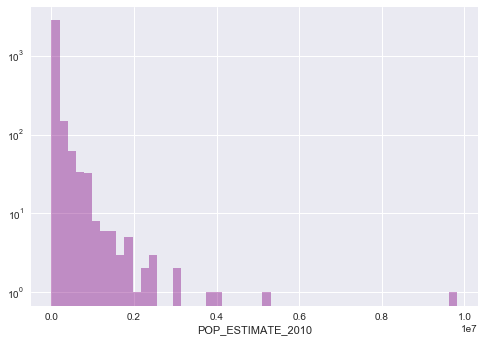

In [10]:
ax = sbn.distplot(popdata['POP_ESTIMATE_2010'],kde=False,color='purple')
ax.set_yscale('log')

We can see that the vast majority of counties have rather small populations, but it's difficult to see the population distribution for the smaller counties. Instead, let's look at the logarithm of the population:

[<matplotlib.text.Text at 0x965a810>, <matplotlib.text.Text at 0x94aff70>]

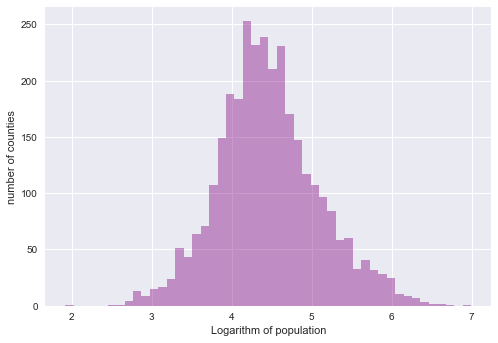

In [11]:
popdata['LogPop'] = numpy.log10(popdata['POP_ESTIMATE_2010'])
ax = sbn.distplot(popdata['LogPop'],kde=False,color='purple')
ax.set(ylabel='number of counties',xlabel='Logarithm of population')

OK, that's easier to look at.  The log-plot shows that counties commonly have between 10,000 and 100,000 people.

Now, let's add a couple more derived features to the dataset.  One interesting feature is the fractional population increase in each county from 2010 to 2016. In other words, the population change divided by the total population.  We'll also add a binary feature (0 or 1) which indicates whether the county's population increased or not between 2010 and 2016.  We'll also rename some of the columns for the education-related data, just to make the titles shorter and easier to work with.

In [12]:
#Add derived population features
popdata['NPopChange'] = popdata['POP_ESTIMATE_2016'] - popdata['POP_ESTIMATE_2010']
#print(popdata.head())
#print("done")

popdata['PercentPopIncrease'] = 100*popdata['NPopChange']/popdata['POP_ESTIMATE_2010']
#PopIncreased=1 if population increased, =0 if population decreased or stayed the same
popdata['PopIncreased']=0
popdata.loc[popdata['PercentPopIncrease']>0.0, 'PopIncreased'] = 1

popdata.rename(columns={'Percent of adults with less than a high school diploma, 2011-2015': 'percentNoHSDipl'}, inplace=True)
popdata.rename(columns={'Percent of adults with a high school diploma only, 2011-2015': 'percentOnlyHSDipl'}, inplace=True)
popdata.rename(columns={"Percent of adults completing some college or associate's degree, 2011-2015": 'percentPartialCollege'}, inplace=True)
popdata.rename(columns={"Percent of adults with a bachelor's degree or higher, 2011-2015": 'percentCollegeDegree'}, inplace=True)
    

Now, let's make a map of the U.S. which shows the population of each county.  To do this, we'll use the BaseMap python library.  We'll also need to download a shape file which contains information about the location and shape of each U.S. county. This file is available from the U.S. census website:
https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html.
Here's the python function we'll use to make the map and to color each county according to the values in our dataset:

In [13]:
def plotCountyMap(dataFrame, columnName, nColors, colorMap='Reds',label='', minRange=0, maxRange=0):

    
    #US Map with county outline, downloaded from https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html
    countyShapeFile=r'C:\Users\Brian\Downloads\cb_2016_us_county_500k\cb_2016_us_county_500k'

    debugMode=False
#    print("now plotting map for",columnName)
   # nColors=10


    #plot maps
    dict_county_colors={}

    cmap = plt.get_cmap(colorMap,nColors)
    if minRange==0 and maxRange==0:
        minRange = dataFrame[columnName].min()
        maxRange = dataFrame[columnName].max()
    norm = Normalize(vmin=minRange,vmax=maxRange)
    mapper = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
    

    for row in dataFrame.itertuples():
        fips = getattr(row,'FIPS')
        myVal = getattr(row,columnName)
      #  myColor = calcColor(myVal,nColors,minval,maxval)
      #  print("fips =",fips,"myVal = ",myVal,"color=",myColor)
        myColor = mapper.to_rgba(myVal)
      #  print("fips =",fips,"myVal = ",myVal,"color=",myColor)
        dict_county_colors[fips] = myColor

#    print("done setting colors for counties")


    patches = dict(map(lambda color:(color,[]),dict_county_colors.values()))
    fig, axes = plt.subplots()


    myMap = Basemap(llcrnrlon=-129.0, llcrnrlat=23.0, urcrnrlon=-66.0, urcrnrlat=52.0, resolution='f',projection='merc',lat_0=38.0, lon_0=-97.0)

#    print("created basemap")

    myMap.drawmapboundary(fill_color='aqua')
    myMap.fillcontinents(color='gray',lake_color='aqua')
    myMap.drawcoastlines()

    myMap.readshapefile(countyShapeFile,'counties',drawbounds=False)

    for info, shapes in zip(myMap.counties_info, myMap.counties):
        #print("info is",info['GEOID'])
        #value = int(info['GEOID'])
        #print(value)
        #newval = value + 2
        #print(newval)
        
        try:
            color = dict_county_colors[int(info['GEOID'])]
           # print("got the color",color)
            patches[color].append( Polygon(numpy.array(shapes), True) )
        except Exception as exc:
            #shape file includes U.S. territories which we ignore in this study, so
            #this is not a problem
            if(debugMode):
                print("missing ID ",exc)
            
    for color in patches:
        hexcolor = rgb2hex(color)
        axes.add_collection(PatchCollection(patches[color],facecolor=hexcolor, edgecolor='k',linewidths=0.3,zorder=2))


    colax = fig.add_axes([0.25,0.1,0.5,0.05])
    cbar = ColorbarBase(colax, cmap=cmap, norm=norm, orientation='horizontal')
    cbar.ax.set_xlabel(label)
#    plt.show()

    plt.savefig(r'C:\Users\Brian\Downloads\testFig5dpi300.png',dpi=300)  #dpi=300 is good enough resolution

Now we can plot the population (or rather, the logarithm of the population) of each county on the map:

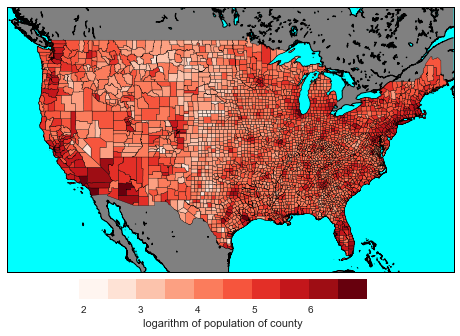

In [14]:
#warning: code takes a while to run
plotCountyMap(popdata,'LogPop',nColors=10,label="logarithm of population of county")

Let's see what were the fastest-growing counties from 2010-2016:

In [33]:
print(popdata[['State','Area_Name','POP_ESTIMATE_2010','PercentPopIncrease']].sort_values(['PercentPopIncrease'],ascending=False).head())

     State         Area_Name  POP_ESTIMATE_2010  PercentPopIncrease
2052    ND   McKenzie County               6398           97.264770
2078    ND   Williams County              22586           52.027805
2718    TX     Loving County                 83           36.144578
2056    ND  Mountrail County               7720           32.668394
390     FL     Sumter County              94280           31.518880


Three of the top-four fastest-growing counties were in western North Dakota, clearly related to the famous oil boom in that region.

Now, let's plot the percentage population change of each county:

In [ ]:
plotCountyMap(popdata,'PercentPopIncrease',nColors=9,colorMap='bwr',minRange=-18,maxRange=18,label="percent change in population, 2010-2016")

We see that the population growth is definitely not evenly distributed over the entire U.S.  Certain states have higher population growth than others.  There is high population growth in some of the western states and in Florida, whereas there is low growth or even population decline in the northeast and parts of the central U.S. 

In order to use the state information later on, it is helpful to convert the name of each state into a numerical code.  We'll define the state code such that the states are ordered in terms of the fraction of counties in the state having an increasing population. So, the state with the smallest fraction of counties that are growing will have a code of 1, and higher codes will represent states with higher fractions of counties experiencing growth.

Furthermore, there are certain states that don't have many counties in them; we will merge these states together so that each 'state' has a significiant number of counties.  

In [18]:
#merge together states (including DC) that don't have very many counties.
popdata['State'] = popdata['State'].replace(['CT','RI','MA'],'LowerNE')
popdata['State'] = popdata['State'].replace(['VT','NH','ME'],'UpperNE')
popdata['State'] = popdata['State'].replace(['DC','MD','DE'],'MidAt')
popdata['State'] = popdata['State'].replace(['CA','HI'],'Pacif')

print("There are %d different 'states' in our database."%len(popdata['State'].unique()))

#Convert state name into a numerical value: 
    ##1= The 'state' with the lowest fraction of counties having pop. increase; 
    ##44: The 'state' with the highest fraction of counties having pop. increase
#print(popdata[['State','PopIncreased']].groupby(['State'], as_index=False).mean())
dataGrpByState = popdata[['State','PopIncreased']].groupby(['State'], as_index=False).mean()
#print(dataGrpByState)
dataGrpByState = dataGrpByState.sort_values(['PopIncreased'])
#print(dataGrpByState)
stateToCodeDict = {}
myCode=1
for row in dataGrpByState.itertuples():
#    print("State=",row.State," ; frac = ",row.PopIncreased)
    stateToCodeDict[row.State] = myCode
    myCode+=1
print(stateToCodeDict)
popdata['StateCode'] = popdata['State'].map(stateToCodeDict)


There are 44 different 'states' in our database.
{'IL': 1, 'KS': 2, 'WV': 3, 'MS': 4, 'IA': 5, 'NY': 6, 'OH': 7, 'AR': 8, 'MO': 9, 'AL': 10, 'NE': 11, 'MI': 12, 'PA': 13, 'NM': 14, 'IN': 15, 'UpperNE': 16, 'KY': 17, 'LA': 18, 'WI': 19, 'MN': 20, 'OK': 21, 'NV': 22, 'LowerNE': 23, 'GA': 24, 'VA': 25, 'NC': 26, 'SC': 27, 'ID': 28, 'TN': 29, 'NJ': 30, 'ND': 31, 'TX': 32, 'SD': 33, 'WY': 34, 'AK': 35, 'MT': 36, 'MidAt': 37, 'Pacif': 38, 'CO': 39, 'FL': 40, 'OR': 41, 'UT': 42, 'AZ': 43, 'WA': 44}


# Closer examination of the data

Our ultimate goal is to create a classifier that can predict whether a county's population will increase or decrease.  In order not to bias our predictions, it is good to separate the data used to make the predictions from the data we're trying to predict.  Let's split our data into a training, validation, and test set. To make sure the three sets are roughly equivalent (and thus avoid biases), we'll randomly assign the data to one of the three sets.

Here I have a small function for randomly splitting the data up:

In [19]:
def  splitDataTrainValidateTest(origData, trainFrac, validateFrac, ranSeed):
    numpy.random.seed(ranSeed)
    permutation = numpy.random.permutation(origData.index)
    nTotal = len(origData)
    print("nTotal=",nTotal)
    print("Splitting data with %i rows into train, validation, and test data"%nTotal)
#    print(permutation)
    endOfTrain=int(nTotal*trainFrac)
#    print("train end=",endOfTrain)
    
    endOfValidate=int(nTotal*(trainFrac+validateFrac))
#    print("validate end=",endOfValidate)
    trainData = origData.ix[permutation[:endOfTrain]]
#    print("hello")
    validateData = origData.ix[permutation[endOfTrain:endOfValidate]]
    testData = origData.ix[permutation[endOfValidate:]]
    return trainData, validateData, testData

Let's use 60% of the data for training, 20% for validation, and 20% for testing:

In [ ]:
 train, validate, test = splitDataTrainValidateTest(popdata, trainFrac=0.6, validateFrac=0.2, ranSeed=3242)

Now we'll examine some trends in the training data.  We're interested in understanding whether a county's population will grow or not.  Let's see how the probability that a county's population increases depends on other variables.  We'll plot the fraction of counties having an increasing population versus the average income of the county's inhabitants.

In [ ]:
ax = sbn.regplot(x=popdata['Median_Household_Income_2015'],y=popdata['PopIncreased'],x_bins=10,fit_reg=None)
ax.set(ylabel='Fraction of counties whose population grew',xlabel='Median household income ($), 2015')

We see that there is a strong correlation between a county's income and the likelihood that the county's population grew.  Only about 15% of counties with an average household income of \$35,000 had a growing population, whereas about 85% of counties in the highest income bracket (~\$65,000) had a growing population.

Now let's look at a few other trends.  We'll see how population growth correlates with:
- The absolute population of the county (as of 2010).
- Unemployment rate
- Urban/Rural distinction. For this, we'll use the rural-urban continuum code, documented here: https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/documentation/.  This code ranges from 1 (most urban) to 9 (most rural).
- Education level.  For this, we'll look at the percentage of people having a college degree, and the percentage of people only having a high school diploma.

[<matplotlib.text.Text at 0x1bc11610>, <matplotlib.text.Text at 0xaecfff0>]

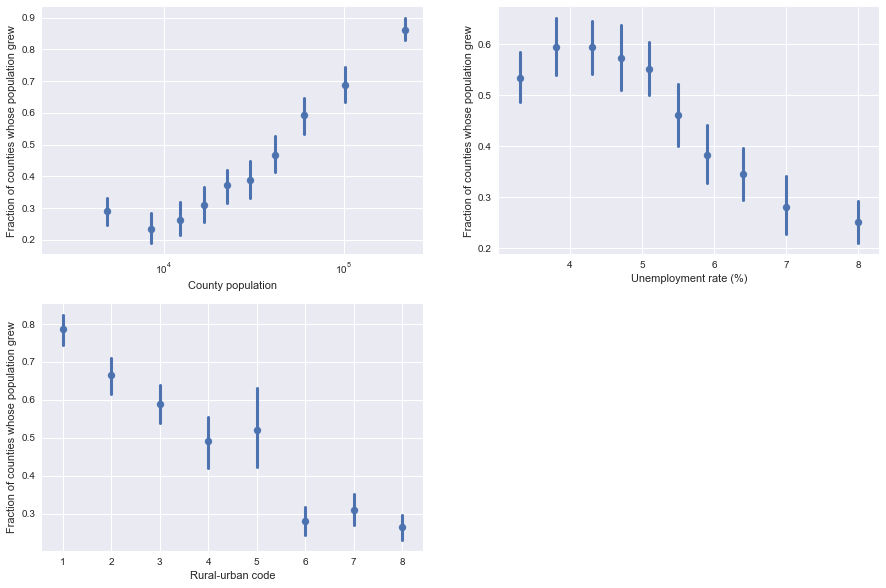

In [22]:
plt.figure(figsize=[15,10])
plt.subplot(221)
ax = sbn.regplot(x=popdata['POP_ESTIMATE_2010'],y=popdata['PopIncreased'],x_bins=10,fit_reg=None)
ax.set(ylabel='Fraction of counties whose population grew',xlabel='County population')
ax.set_xscale('log')

plt.subplot(222)
ax = sbn.regplot(x=popdata['Unemployment_rate_2015'],y=popdata['PopIncreased'],x_bins=10,fit_reg=None)
ax.set(ylabel='Fraction of counties whose population grew',xlabel='Unemployment rate (%)')

plt.subplot(223)
ax = sbn.regplot(x=popdata['Rural_urban_continuum_code_2013'],y=popdata['PopIncreased'],x_bins=range(1,9),fit_reg=None)
ax.set(ylabel='Fraction of counties whose population grew',xlabel='Rural-urban code')


[<matplotlib.text.Text at 0xaf78c70>, <matplotlib.text.Text at 0xaf74f50>]

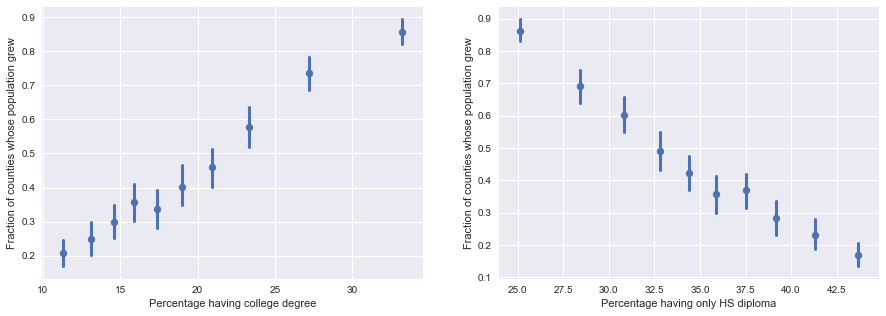

In [23]:
plt.figure(figsize=[15,5])
plt.subplot(121)
ax = sbn.regplot(x=popdata['percentCollegeDegree'],y=popdata['PopIncreased'],x_bins=10,fit_reg=None)
ax.set(ylabel='Fraction of counties whose population grew',xlabel='Percentage having college degree')

plt.subplot(122)
ax = sbn.regplot(x=popdata['percentOnlyHSDipl'],y=popdata['PopIncreased'],x_bins=10,fit_reg=None)
ax.set(ylabel='Fraction of counties whose population grew',xlabel='Percentage having only HS diploma')

From these plots, we can summarize the following trends.  Counties are more likely to have a growing population 
if they:
- have a high average household income.
- are more urban.
- have a higher population.
- have low unemployment.
- are highly educated.

# Using Machine Learning to predict whether a county's population will increase

In [24]:
mlVars = ['LogPop','StateCode','Median_Household_Income_2015','Rural_urban_continuum_code_2013','percentOnlyHSDipl','PopIncreased']
train = train[mlVars]
validate = validate[mlVars]
test = test[mlVars]

We are going to train our classifiers to predict "PopIncreased," so we prepare the datasets accordingly:

In [26]:
train_x = train.drop(['PopIncreased'],axis=1)
train_y = train['PopIncreased']
#print(train_x.head())
   
validate_x = validate.drop(['PopIncreased'],axis=1)
validate_y = validate['PopIncreased']

test_x = test.drop(['PopIncreased'],axis=1)
test_y = test['PopIncreased']

Now we set up a function to train our classifier on the training data, and then calculate the fraction of the time that the classifier correctly predicts PopIncreased for the validation data and for the training data.

In [27]:
def AddClassifier(tool, train_x, train_y, validate_x, validate_y, results, title):
    tool.fit(train_x,train_y)
#    pred_valid[title] = tool.predict(train_x)
    accuracy_pred_valid = tool.score(validate_x,validate_y)*100
    accuracy_pred_train = tool.score(train_x,train_y)*100
    results.append( [title, accuracy_pred_valid, accuracy_pred_train] )

Now we actually run the calculations, for a variety of different machine learning techniques, using Python's scikit-learn library.  We then rank their performance based on their prediction accuracy for the validation dataset.

In [28]:
mlResults=[] #pd.DataFrame(columns=['Accuracy on Validation Set','Accuracy on Training Set']) 
pred_validate={}

#For this study, we will hard-code random_state in order to ensure exact reproducibility of results
randomCode=24313
tool = LogisticRegression()
AddClassifier(tool, train_x, train_y, validate_x, validate_y, mlResults,"Logistic")
tool = DecisionTreeClassifier(random_state=randomCode)
AddClassifier(tool, train_x, train_y, validate_x, validate_y, mlResults,"Decision Tree")    
tool = SVC()
AddClassifier(tool, train_x, train_y, validate_x, validate_y, mlResults,"SVC")
tool = RandomForestClassifier(random_state=randomCode)
AddClassifier(tool, train_x, train_y, validate_x, validate_y, mlResults,"Random Forest")
tool = Perceptron()
AddClassifier(tool, train_x, train_y, validate_x, validate_y, mlResults,"Perceptron")
tool = KNeighborsClassifier()
AddClassifier(tool, train_x, train_y, validate_x, validate_y, mlResults,"KNN")

columnLabels=['Classifier','Accuracy on Validation Set','Accuracy on Training Set']
dfResults=pd.DataFrame.from_records(mlResults,columns=columnLabels)
dfResults = dfResults.sort_values(['Accuracy on Validation Set'],ascending=False)
dfResults

,Classifier,Accuracy on Validation Set,Accuracy on Training Set
3,Random Forest,76.910828,98.248408
0,Logistic,76.592357,78.025478
1,Decision Tree,73.248408,100.000000
5,KNN,61.464968,75.955414
2,SVC,55.254777,100.000000
4,Perceptron,55.095541,54.830149


We can see that the Random Forest and Logistic Regression models do the best job, both correctly predicting a county's population change over 75% of the time.  We also see that most of the classifiers suffer from "overtraining"; i.e. they perform a lot better on the training set than on the validation set.  This underscores the importance of only using the validation set to judge the performance of the classifiers.  The only models that don't overtrain are the logistic model and the perceptron.

Based on the performance of the classifiers on the validation set, we will choose the Random Forest model as our final classifier.  Now we will check the classifier's performance on the test set (it is better to check the final performance on an independent test set, rather than on the validation set, since we chose the best classifier based on the validation data, which could bias our result).

In [30]:
finalResults=[] #pd.DataFrame(columns=['Accuracy on Test Set','Accuracy on Training Set']) 

tool = RandomForestClassifier(random_state=randomCode)
AddClassifier(tool, train_x, train_y, test_x, test_y, finalResults,"Random Forest")
columnLabels2=['Classifier','Accuracy on Test Set','Accuracy on Training Set']
dfResults2=pd.DataFrame.from_records(finalResults,columns=columnLabels2)
dfResults2

,Classifier,Accuracy on Test Set,Accuracy on Training Set
0,Random Forest,74.085851,98.248408


The accuracy on the test set is 74%, similar to the 77% accuracy on the validation set.  Finally, let's look at the confusion matrix for the classifier.  

In [31]:
tool.fit(train_x,train_y)
pred_rf = tool.predict(test_x)

pd.crosstab(test['PopIncreased'],pred_rf,rownames=['Actual Pop. Increase'],colnames=['Predicted Pop. Increase'])

Predicted Pop. Increase,0,1
Actual Pop. Increase,,
0,271,65
1,98,195


The confusion matrix compares the *predicted* population increase (1: population of county increased, 0 otherwise) of each county in the test set versus whether the county's population *actually* increased. There were 369 counties in the test set that were predicted not to have a population increase.  Of these, 271 actually didn't increase in population (so the prediction was correct), and 98 did increase in population (so the prediction was wrong).  On the other hand, 260 counties were predicted to grow in population.  Of these, 195 actually did increase in population (prediction was correct), and 65 did not increase in population (prediction was wrong). 